# Projeto 3 Ciência dos Dados.

## Tema: FIFA18
## Objetivo: Tendência de um jogador virar craque

### Alunos: Augusto Franco e Pedro Daher

### O objetivo deste trabalho é averiguar qual a tendência do jogador virar craque, baseadoem atributos do mesmo.

In [1]:
#importando bibliotecas que iremos usar

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
import os
from numpy import arange
from scipy.stats import skew
from sklearn.utils import shuffle
from scipy.stats.stats import pearsonr
from sklearn import cross_validation, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet as ElasticNetImpl
from sklearn.preprocessing import LabelEncoder
from subprocess import check_output
from sklearn.utils import shuffle
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

warnings.filterwarnings('ignore')

C:\Users\Augusto\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Augusto\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Importa a planilha que contem os dados utilizados. Esta planilha foi importada de www.kaggle.com

In [2]:
fifa = pd.read_csv('CompleteDataset.csv')

#### Normaliza a coluna 'Value' (valor do jogador) e a coluna 'Wage' (salário do jogador por semana)

In [3]:
def extrai(value):
    out = value.replace('€', '')
    if 'M' in out:
        out = float(out.replace('M', ''))*1000000
    elif 'K' in value:
        out = float(out.replace('K', ''))*1000
    return float(out)

In [4]:
fifa['Value'] = fifa['Value'].apply(lambda x: extrai(x))
fifa['Wage'] = fifa['Wage'].apply(lambda x: extrai(x))

#### Embaralha e divide a planilha em 2. Uma contendo 15000 jogadores (train) e outra com aproximadamente 3000 jogadores (test)

In [24]:
fifa = shuffle(fifa)

In [25]:
train = fifa.iloc[:15000]
test = fifa.iloc[15000:]

#### Escolhendo os valores que serão utilizados para calcular nosso objetivo, que é o "Value"

In [26]:
x = [ 'Potential', 'Overall', 'Wage', 'Age', 'Special'] #atributos utilizados para calcular um value
y = ['Value'] #objetivo

#### Verificando o quanto Overall influencia no Valor do jogador

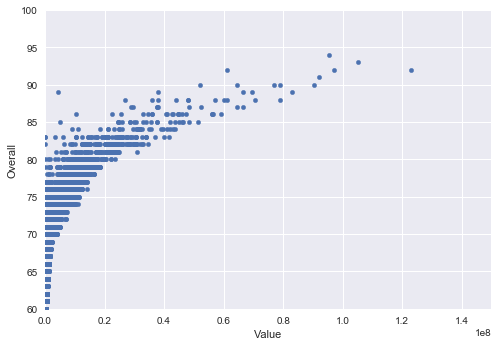

In [27]:
var = 'Value'
data = pd.concat([train['Overall'], train[var]], axis=1)
data.plot.scatter(x=var, y='Overall', ylim=(60,100), xlim=(0,150000000));

#### Verificando o quanto Overall influencia no Valor do jogador

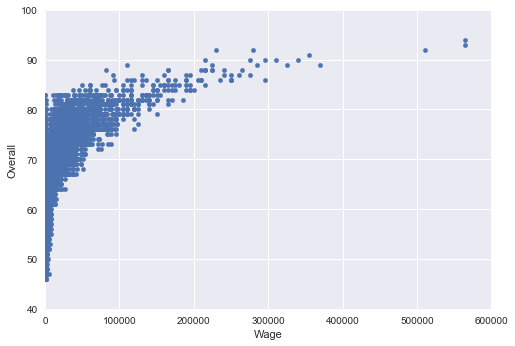

In [28]:
var = 'Wage'
data = pd.concat([train['Overall'], train[var]], axis=1)
data.plot.scatter(x=var, y='Overall', ylim=(40,100), xlim=(0,600000));

#### Verifica, através da cor azul, quais as variáveis que mais influenciam a variável 'Value'. Quanto mais próximo de azul escuro for o quadrado da intersecção, maior é a correlação entre as duas variáveis.

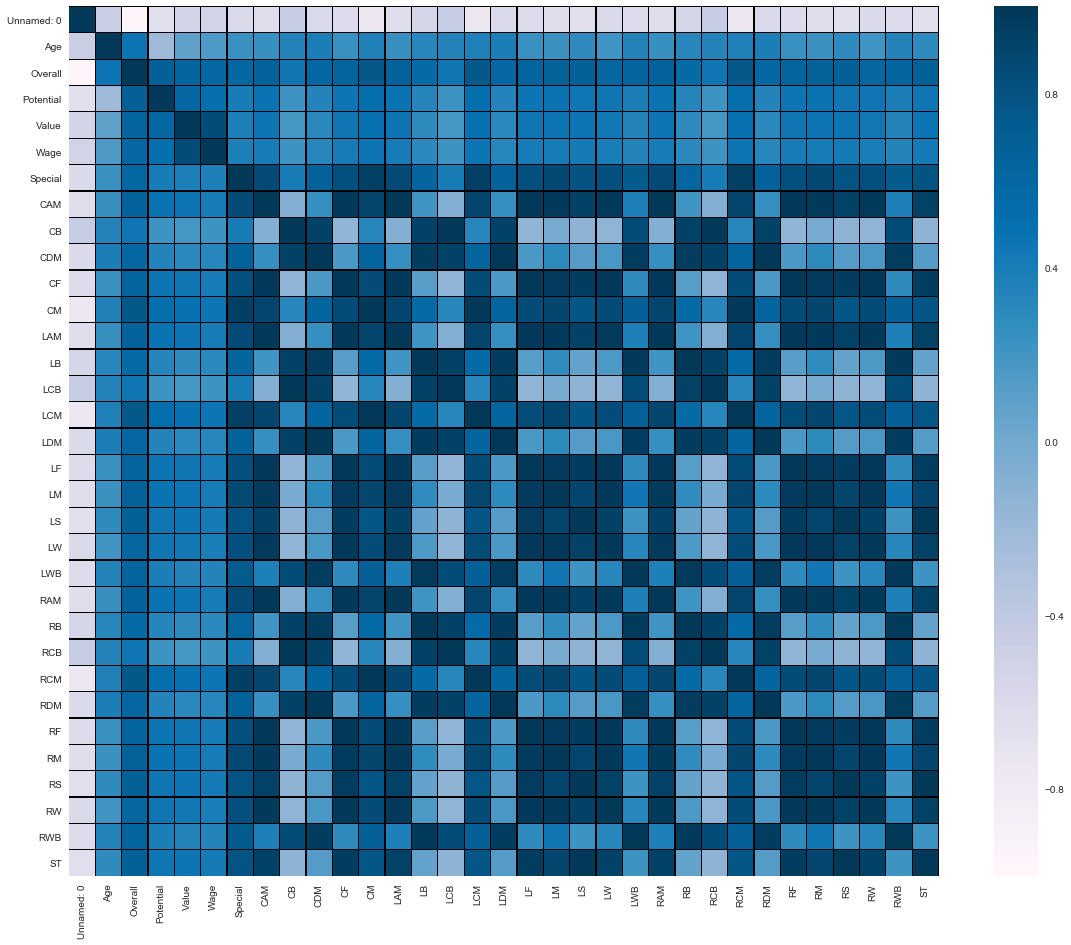

In [29]:
corr = fifa.drop('ID', axis = 1).corr()

fig = plt.figure(figsize=(20,16))

ax = sns.heatmap(corr, 
                 xticklabels=corr.columns.values,
                 yticklabels=corr.columns.values,
                 linewidths=0.25,
                 vmax=1.0, 
                 square=True, 
                 cmap = 'PuBu', 
                 linecolor='black', 
                 annot=False
                )

#### Faremos, agora, a correlação entre as variáveis, com o alvo em Value. Agora o gráfico será plotado em barras e possuirá qual o valor da correlação entre as variáveis

In [30]:
train.drop(["Photo", "Flag","Club Logo","Name"],1,inplace=True)

In [31]:
train.drop("ID",1,inplace=True)

In [32]:
l_encode = LabelEncoder()
obj_feat = ["Club", "Nationality","Preferred Positions"]
for var in obj_feat:
    train[var] = l_encode.fit_transform(train[var].astype(str))
train.shape

(15000, 70)

In [33]:
def clean_values(x):
    try:
        if len(x)>2:
            y = x[:2]
            return y
        else:
            return x
    except TypeError:
        return x
columns_to_clean = [col for col in train.columns if col not in ["Age","Nationality",
                                                                  "Overall","Potential",
                                                                 "Club","Value","Wage",
                                                                  "Special"]]
for col in columns_to_clean:
    train[col] = train[col].apply(lambda x : clean_values(x))

In [34]:
train = train.dropna(axis=1, how="any")

In [35]:
def modelfit(alg, dtrain, features, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    alg.fit(dtrain[features],dtrain["Value"] )
        
    
    dtrain_predictions = alg.predict(dtrain[features])

   
    cv_score = cross_validation.cross_val_score(alg, dtrain[features], dtrain["Value"], cv=cv_folds,
                                                scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain["Value"], dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),
                                                                             np.std(cv_score),np.min(cv_score),
                                                                              np.max(cv_score)))
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, features).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
RMSE : 3.361e+05
CV Score : Mean - 6.643e+05 | Std - 2.016e+05 | Min - 4.739e+05 | Max - 1.221e+06


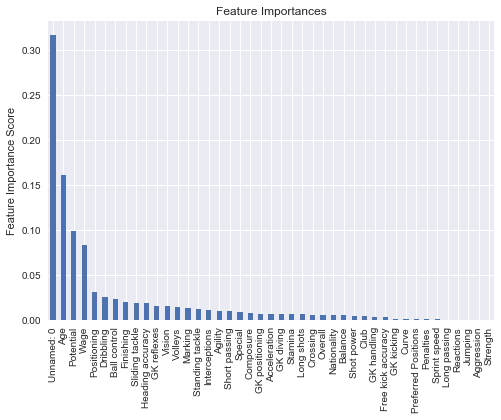

In [36]:
#Grau de correlação entre outras variáveis, em relação ao valor
features = [i for i in train.columns if i != "Value"]
target = "Value"
gbm0 = GradientBoostingRegressor(random_state=7)
modelfit(gbm0, train, features)

#### O primeiro gráfico apresenta a frequência dos valores dos jogadores. Já o segundo gráfico traduz o primeiro em pontos e possui uma reta que satisfaz estes vários pontos. Nota-se que há uma sequência no segundo gráfico de valores iguais a zero. Isso ocorre pois os valores entre os salários dos jogadores são muito discrepantes (exemplo: um jogador bom ganha 600.000 euros por semana, enquanto outros ganham 800 euros por semana). Estes que ganham 800 euros por semana foram arredondados para 0.8 mil euros por semana, e, devido à enorme discrepância, pode-se igualá-los a zero.

In [37]:
#Jogadores com salário igual a 0.8K foram lidos como sendo 0. Para corrigir isso, colocamos valores e salários abaixo de 1K como 
#sendo iguais a 1K (arredondamento pra cima).
train.Value[train.Value==0]=1
train.Wage[train.Wage==0]=1

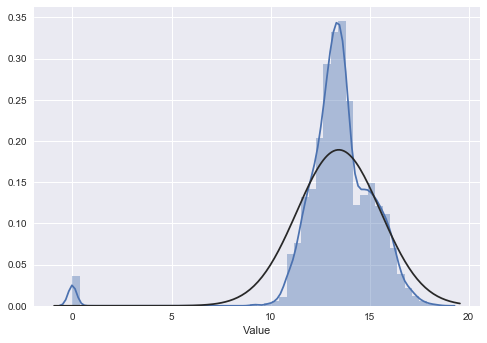

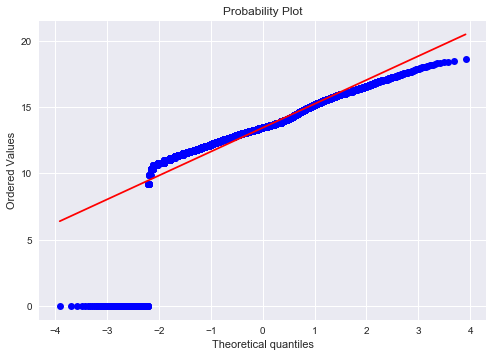

In [38]:
sns.distplot(np.log(train['Value']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(train['Value']), plot=plt)

### Função que realiza a regressão de Ridge na planilha Treino

In [43]:
def ridge_regression(train, x, alpha):
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(train[x],train['Value'])
    y_pred = ridgereg.predict(train[x])
    return(y_pred)

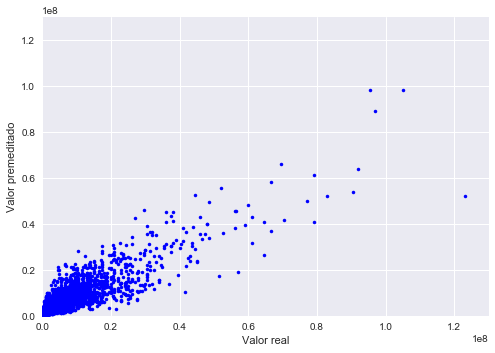

In [45]:
ridge = ridge_regression(train, x, 1e-20)
plt.plot(train['Value'],ridge,'.', color="blue")
plt.axis([0, 130000000, 0, 130000000])
plt.xlabel("Valor real")
plt.ylabel("Valor premeditado")
plt.show()

In [41]:
r_R = ridge_regression(test, x, 1e-20)
print((mean_squared_error(test['Value'],r_R))**(1/2))

2771253.90741


### Regressão de Ridge na planilha de teste

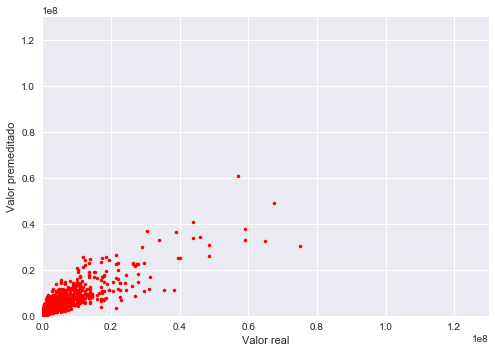

In [51]:
ridgetest = ridge_regression(test, x, 1e-20)

plt.plot(test['Value'],ridgetest,'.', color="red")
plt.axis([0, 130000000, 0, 130000000])
plt.xlabel("Valor real")
plt.ylabel("Valor premeditado")
plt.show()

# O trabalho

### Primeiramente, para a realização de um melhor trabalho, as variáveis 'Value' e 'Wage' foram corrigidas numericamente para poderem ser trabalhadas juntamente com outras variáveis numéricas.
### Após isto, técnicas para verificar a correlação entre algumas variáveis e seus respectivos valores foram utilizadas. Entre estas técnicas estão: dois gráficos de coordenadas (um sobre características gerais pelo valor - resultou em uma tendência exponencial e outro sobre salário semanal pelo valor - também resultou em uma tendência exponencial); um "gráfico de calor" que traduz a correlação entre as variáveis através das cores dos quadrados em intersecções; e por último um gráfico de barras que traduz as correlações em valores entre as variáveis mais significantes em relação ao valor.
### Para finalizar, um gráfico (em azul) foi plotado levando em consideração 5 atributos significantes: 'Potential', 'Overall', 'Wage', 'Age' e 'Special'. O resultado final foi um gráfico do valor real pelo valor premeditado.

# Conclusão

### O resultado atingido foi excelente. Nota-se que o gráfico em vermelho é praticamente uma miniatura do gráfico em azul. Isto é, a predição foi um sucesso. Outra evidência do sucesso foi a proximidade dos valores reais com os premeditados. Para comprovar esta equivalência, basta traçar uma reta com tg=1 (inclinação de 45 graus) e perceber que os valores estão muito próximos à esta reta.

# O trabalho em grupo do Augusto com o Pedro

### A dupla apresentou bastante dificuldade no começo do trabalho (durante a primeira semana), mas com o auxilio dos professores Kelly e Ian, além dos colegas em sala de aula e monitorias, a dupla alcançou seu objetivo na reta final da entrega.
### Ambos os alunos tiveram participação no trabalho e puderam realizar um intercâmbio de ideias que ajudou a plena fluência do projeto.